In [22]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import Audio
import ipywidgets as widgets
from scipy.spatial.distance import pdist, squareform, cdist

# Methods of Audio Analysis in Python - Lesson 3
# Self-similarity, Kernels and Audio Segmentation

In this lesson we'll introduce another method to extract structure from audio data (or any ordered sequence for that matter), but this time in the temporal direction (recall that for the cepstrum we were interested in the frequency-axis). We do this by comparing the signal at each timestep to the past (and future) values in order to obtain a measure of its **self-similarity**. This is not much different from computing the autocorrelation of some sequence, except that we are afforded more freedom in deciding what *similarity* actually means in the given context. The power of this method, however, comes from the way we choose to *represent* this information. We organise the similarity values into a matrix (the **self-similarity matrix** (**SSM**)), which allows us to compare different segments across time over the whole input clip. This not only permits the use of analytical methods to detect structure in the signal, but also lets us easily *visualise* this information. The importance of effective visualisation tools should not be underestimated for explorative analysis. The final advantage of the self-similarity method is that it is extremely versatile: it is not in any way reliant on spectral decomposition (even though that's where we'll apply it in this notebook), but works for many different types of signals and feature representations. It can also be used to creatively solve many types of problems of which we'll give a few simple examples in today's lecture.

## Self-similarity matrix

We will use the following 30 second sample of a jazz song as a running example. Let's load it up and give it a listen.

In [13]:
# Original recording courtesy of Tri-Tachyon @ freesound.org, converted to WAV.
# https://freesound.org/people/Tri-Tachyon/sounds/466478/
# Licensed under the Creative Commons Attribution 4.0 license
# https://creativecommons.org/licenses/by/4.0/
sr, jazz = wavfile.read('audio/jazz.wav')
# Normalise
jazz = jazz / np.abs(jazz).max()
print(f'Successfully read audio with sampling rate {sr} Hz, {jazz.shape[1]} channels and length {jazz.shape[0] / sr:.1f} s.')

Successfully read audio with sampling rate 44100 Hz, 2 channels and length 33.1 s.


/var/folders/jb/3smwxhqs6x19hclczq9prsw80000gq/T/ipykernel_21756/3562071075.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, jazz = wavfile.read('audio/jazz.wav')


In [218]:
# note that we need the transpose since IPython and SciPy use the opposite convention for the array shape
Audio(jazz.T, rate=sr)

We can hear that in this relaxed piece (which is in $4\atop 4$ signature) there's a 4 bar sequence (call it **A**) that repeats twice before the solo guitar (and the finger snapping!) kicks in for another 8 bars. The drum beat also changes slightly for this latter part, which we denote by **B**. So the structure of this song is **AAB**. Our aim is to be able to detect this algorithmically, but first let's see what we can notice from the spectrogram.

In [329]:
# We use some sensible values for the FFT parameters. It could be useful to tweak these
# depending on what you want to achieve.
window_len = 1024
window_overlap = window_len // 4
mode = 'magnitude'
f, t, Sxx = signal.spectrogram(jazz[:, 0], sr, nperseg=window_len, noverlap=window_overlap, mode=mode)

We'll plot the spectrogram on the decibel scale. You can again use the slider to zoom in on the lower frequencies.

> 🔊 Exercise: Try out different FFT parameters and computing the power spectrum instead of the magnitude (mode='psd'), for example. How does this affects the resulting visualisation?

In [330]:
# As mentioned in lecture 1, it is usually helpful to convert to
# the logarithmic decibel scale.
Sxx_dB = 10*np.log10(Sxx / np.max(Sxx))

def plot(y_UB):
    fig, ax = plt.subplots(figsize=(12, 5))
    p = ax.pcolormesh(t, f, Sxx_dB, cmap='magma', shading='auto',
    # For other types of spectrograms you might have to adjust the vmin
    # and vmax values, which control the colormap scaling, or just leave
    # them out completely (i.e. scale automatically)
                      vmin=-50, vmax=0)
    ax.set_ylim(0, y_UB)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Spectrogram of jazz song')
    fig.colorbar(p, label='dBFS')
    plt.show()

widgets.interact(plot, y_UB=widgets.IntSlider(value=22000, min=500, max=22000,
                                             description='Max frequency'));

interactive(children=(IntSlider(value=22000, description='Max frequency', max=22000, min=500), Output()), _dom…

It's quite easy to notice some beat structure in thhe spectrogram, which shows up as brighter vertical lines (when the signal's energy increases across the spectrum). We'll return to this later, but let's compute the self-similarity matrix first. To do this we need to decide on a *similarity metric*. We choose to use the standard Euclidean distance, while other common choices include the scalar product (or the normalised cosine distance), Minkowski distance or Manhattan distance. For more examples see [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

Denote the similarity metric by $d$ and our feature sequence (i.e. the sequence of vectors in the frequency-domain that we obtain from the FFT) by $\langle X_{n}\rangle$. The self-similarity matrix $S$ is then given by
$$S=(s_{ij})=d(X_{i}, X_{j}).$$
We will always follow the convention that $d(u, u)=0$ so that equal vectors have similarity score 0 and that $d(u, v)\geq 0$. The similarity score can either be bounded above (as it is, for example, for the cosine distance) or unbounded (like for the Euclidean distance). Be aware though that this is not a universal convention and it varies in the literature. Nevertheless, we can visualise $S$ as a heatmap so that the $s_{00}$ entry of $S$ also correspond to the upper left-hand corner of the visualisation (again, you will find other conventions in the literature). This computation is very easy to do with the help of SciPy's `scipy.spatial.distance.pdist()` and `scipy.spatial.distance.squareform()`. You should refer to the documentation ([here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) and [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html)) to make sure you understand what is happening.

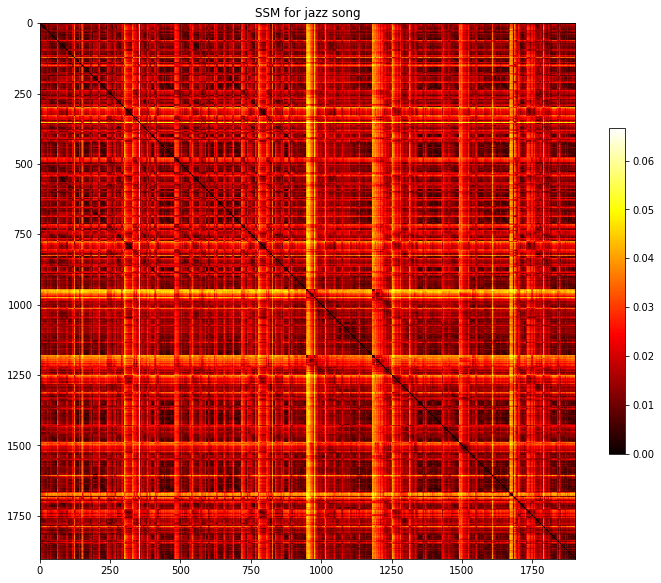

CPU times: user 529 ms, sys: 27.5 ms, total: 557 ms
Wall time: 561 ms


In [331]:
%%time
metric = 'euclidean'
# Note that we have to pass the transpose of Sxx to match with
# the convention of pdist
S = squareform(pdist(Sxx.T, metric=metric))

fig, ax = plt.subplots(figsize=(12, 12))
p = ax.imshow(S, cmap='hot', interpolation='nearest', aspect='equal')
ax.set_title('SSM for jazz song')
fig.colorbar(p, shrink=0.5)
plt.show()

In the SSM plot the $x$- and $y$-axes both correspond to the index of the (frequency) vector sequence, i.e. `Sxx`. In other words, the $(i, j)$ element corresponds to the similarity of `Sxx[:, i]` and `Sxx[:, j]`.
The way to read the plot then is to start from the upper left-hand corner (the (0, 0)-cell) and move along the main diagonal. As we would expect, the main diagonal itself is completely black (since $d(a, a)=0$)...

> 🔊 Exercise: Continue with your FFT parameter experimentation and check also how it affects the SSM. Try out other similarity metrics as well.

## Kernels

In [332]:
def kernel(size=16, smoothing='', strength=2**2, kernel_primitive=None):
    """Computes a kernel to be used for feature extraction from similarity
    matrices. This is done based on the given `kernel_primitive` with the
    default argument corresponding to a checkerboard kernel, as explained
    in Segmentation.ipynb.

    Arguments:
        size
            - Desired size of the kernel (as a square matrix). Note that `size`
                must be divisible by `len(kernel_primitive)` (default: 16)

        smoothing
            - The default argument corresponds to no smoothing, while the value
                'gaussian' applies a Gaussian smoothing with bandwidth given by
                `strength` (default: '')

        strength
            - Bandwidth for Gaussian smoothing (default: 4)

        kernel_primitive
            - Kernel primitive which is enlargened to K. The default argument
                corresponds to checkerboard kernel (default: none)

    Returns:
        K
            - A `size` x `size` numpy array
    """
    # strength is inversely proportional to the standard deviation of the
    # smoothing and thus strength -> 0 corresponds to reduced smoothing,
    # whereas strength -> infty completely dampens the input signal (except
    # at the mean)
    if kernel_primitive is None:
        kernel_primitive = np.array([[-1, 1],
                                    [1, -1]])
    assert size % len(kernel_primitive) == 0, f'Size {size} should be divisible by the primitive length {len(kernel_primitive)}'
    kernel_scale = size // len(kernel_primitive)
    K_raw = np.kron(kernel_primitive, np.ones((kernel_scale, kernel_scale)))
    assert K_raw.shape[0] == K_raw.shape[1]
    if not smoothing:
        K = K_raw
    elif smoothing == 'gaussian':
        # create a grid of X & Y values based on which
        # we compute the Gaussian smoothing
        X = Y = np.arange(0, len(K_raw))
        XX, YY = np.meshgrid(X, Y)
        mu = len(K_raw) // 2
        bw = size / strength
        gauss = np.exp(-.5 * ((XX-mu) ** 2 + (YY-mu) ** 2) / bw ** 2)
        smoothing = gauss * np.ones((len(K_raw), len(K_raw)))
        K = K_raw * smoothing
    else:
        raise Exception("Unknown smoothing specifier.")
    return K

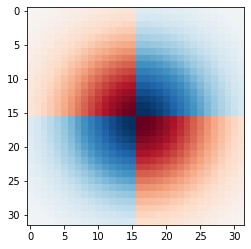

In [333]:
K = kernel(32, 'gaussian', strength=4)
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(K, cmap='RdBu')
plt.show()

In [334]:
%%time
S_nov = signal.convolve2d(S, K / (len(K) ** 2), mode='same')
nov = np.diag(S_nov)

CPU times: user 5.14 s, sys: 37.5 ms, total: 5.18 s
Wall time: 5.18 s


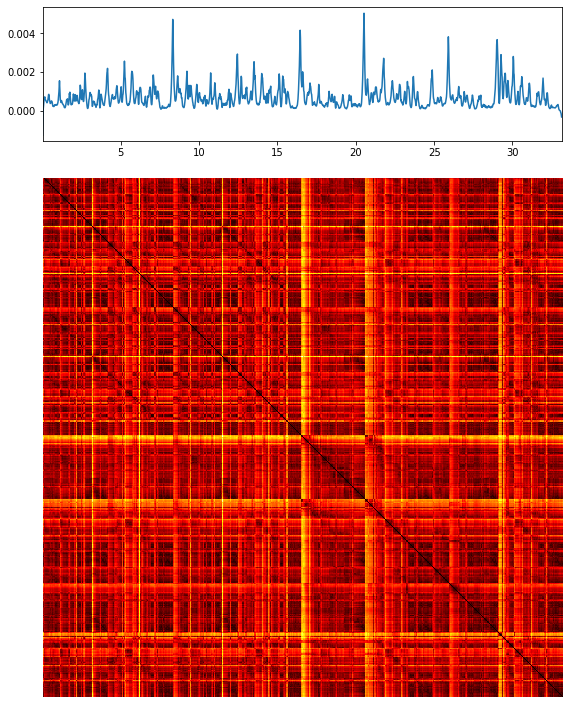

In [335]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, gridspec_kw={'height_ratios': [1, 4]})
ax1.plot(t, nov)
ax1.set_xmargin(0)
ax2.imshow(S, cmap='hot', interpolation='nearest', aspect='equal')
ax2.axis(False)
fig.tight_layout()
plt.show()

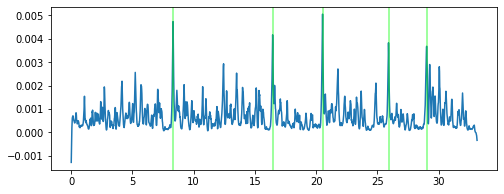

In [336]:
peaks = signal.find_peaks(nov, height=0.003, prominence = 0.003)[0]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, nov)
for p in peaks:
    ax.axvline(t[p], color='lime', alpha=0.5)
plt.show()

## BPM

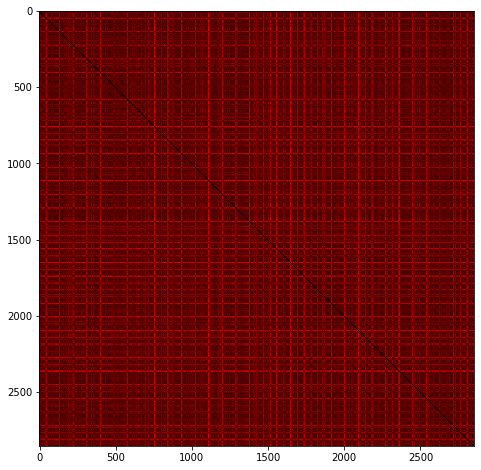

CPU times: user 12.3 s, sys: 93.8 ms, total: 12.4 s
Wall time: 12.4 s


In [187]:
%%time
metric = 'euclidean'
S_dB = squareform(pdist(Sxx_dB.T, metric=metric))
S_dB_nov = signal.convolve2d(S_dB, K / (len(K) ** 2), mode='same')
nov_dB = np.diag(S_dB_nov)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(S_dB, cmap='hot', interpolation='nearest', aspect='equal')
plt.show()

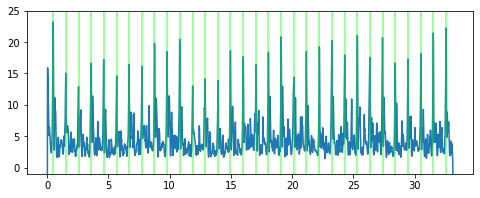

In [190]:
peaks_dB = signal.find_peaks(nov_dB, height=10, prominence=10, distance=50)[0]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, nov_dB)
ax.set_ylim(-1, 25)
for p in peaks_dB:
    ax.axvline(t[p], color='lime', alpha=0.5)
plt.show()

In [192]:
beats = np.array([t[p] for p in peaks_dB])
gaps = np.diff(beats)
mean_gap = np.mean(gaps)
print(f'Detected BPM is {60 / mean_gap:.0f}.')

Detected BPM is 58.


## Where to next?

## Summary

## Further reading

<http://www.musanim.com/wavalign/foote.pdf>